In [ ]:
# default_exp modeling.language_modeling

In [ ]:
#all_slow

In [ ]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling.language_modeling

> This module contains custom models, custom splitters, etc... for both causal and MLM language modeling tasks. This includes things like training BERT from scratch or fine-tuning a particular pre-trained LM on your own corpus.

**This is currently a work in progress** - You've been warned : )

In [ ]:
#export
import os, ast, inspect

from fastcore.all import *
from fastai.callback.all import *
from fastai.data.block import DataBlock, ColReader, ItemGetter, ColSplitter, RandomSplitter
from fastai.imports import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, OptimWrapper, params
from fastai.metrics import perplexity
from fastai.torch_core import *
from fastai.torch_imports import *
from fastprogress.fastprogress import progress_bar,master_bar
from sklearn.metrics import accuracy_score
from transformers import AutoModelForCausalLM, AutoModelForMaskedLM, logging


from blurr.utils import BLURR
from blurr.data.core import HF_TextBlock, BlurrDataLoader, first_blurr_tfm
from blurr.modeling.core import HF_PreCalculatedLoss, Blearner
from blurr.data.language_modeling import (
    HF_LMBeforeBatchTransform, LMType, HF_CausalLMInput, CausalLMStrategy, HF_MLMInput, BertMLMStrategy
)

logging.set_verbosity_error()

In [ ]:
#hide
import pdb

from fastai.data.core import DataLoader, DataLoaders, TfmdDL
from fastai.data.external import untar_data, URLs
from fastcore.test import *
from nbverbose.showdoc import show_doc

from blurr.utils import print_versions
from blurr.modeling.core import HF_BaseModelWrapper, HF_BaseModelCallback, HF_PreCalculatedLoss, hf_splitter

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print_versions('torch fastai transformers')

torch: 1.7.1
fastai: 2.5.0
transformers: 4.9.2


In [ ]:
#hide_input
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


In [ ]:
wiki_path = untar_data(URLs.WIKITEXT_TINY)

train_df = pd.read_csv(wiki_path/'train.csv', header=None)
valid_df = pd.read_csv(wiki_path/'test.csv', header=None)

train_df['is_valid'] = False
valid_df['is_valid'] = True

df = pd.concat([train_df, valid_df])

print(len(df))
df.head()

662


,0,is_valid
0,"\n = 2013 – 14 York City F.C. season = \n \n The 2013 – 14 season was the <unk> season of competitive association football and 77th season in the Football League played by York City Football Club , a professional football club based in York , North Yorkshire , England . Their 17th @-@ place finish in 2012 – 13 meant it was their second consecutive season in League Two . The season ran from 1 July 2013 to 30 June 2014 . \n Nigel Worthington , starting his first full season as York manager , made eight permanent summer signings . By the turn of the year York were only above the relegation z...",False
1,"\n = Big Boy ( song ) = \n \n "" Big Boy "" <unk> "" I 'm A Big Boy Now "" was the first single ever recorded by the Jackson 5 , which was released by Steeltown Records in January 1968 . The group played instruments on many of their Steeltown compositions , including "" Big Boy "" . The song was neither a critical nor commercial success , but the Jackson family were delighted with the outcome nonetheless . \n The Jackson 5 would release a second single with Steeltown Records before moving to Motown Records . The group 's recordings at Steeltown Records were thought to be lost , but they were re...",False
2,"\n = The Remix ( Lady Gaga album ) = \n \n The Remix is a remix album by American recording artist Lady Gaga . Released in Japan on March 3 , 2010 , it contains remixes of the songs from her first studio album , The Fame ( 2008 ) , and her third extended play , The Fame Monster ( 2009 ) . A revised version of the track list was prepared for release in additional markets , beginning with Mexico on May 3 , 2010 . A number of recording artists have produced the songs , including Pet Shop Boys , Passion Pit and The Sound of Arrows . The remixed versions feature both uptempo and <unk> composit...",False
3,"\n = New Year 's Eve ( Up All Night ) = \n \n "" New Year 's Eve "" is the twelfth episode of the first season of the American comedy television series Up All Night . The episode originally aired on NBC in the United States on January 12 , 2012 . It was written by Erica <unk> and was directed by Beth McCarthy @-@ Miller . The episode also featured a guest appearance from Jason Lee as Chris and Reagan 's neighbor and Ava 's boyfriend , Kevin . \n During Reagan ( Christina Applegate ) and Chris 's ( Will <unk> ) first New Year 's Eve game night , Reagan 's competitiveness comes out causing Ch...",False
4,"\n = Geopyxis carbonaria = \n \n Geopyxis carbonaria is a species of fungus in the genus Geopyxis , family <unk> . First described to science in 1805 , and given its current name in 1889 , the species is commonly known as the charcoal loving elf @-@ cup , dwarf <unk> cup , <unk> <unk> cup , or pixie cup . The small , <unk> @-@ shaped fruitbodies of the fungus are reddish @-@ brown with a whitish fringe and measure up to 2 cm ( 0 @.@ 8 in ) across . They have a short , tapered stalk . Fruitbodies are commonly found on soil where brush has recently been burned , sometimes in great numbers ....",False


In [ ]:
#export
class LM_MetricsCallback(Callback):
    """A fastai friendly metric implemented as a callback so that we can handle use cases where we don't
    want to count tokens marked to be ignored or else not count batches where there are no targs
    """
    def __init__(self, **kwargs):
        self.run_before = Recorder
    
        self.custom_metrics_dict = { 'lm_accuracy':None }    
        self.do_setup = True
        
    def setup(self):
        # one time setup code here.
        if (not self.do_setup): return

        # add custom text generation specific metrics
        custom_metric_keys = self.custom_metrics_dict.keys()
        custom_metrics = L([ ValueMetric(partial(self.metric_value, metric_key=k), k) for k in custom_metric_keys ])
        self.learn.metrics = self.learn.metrics + custom_metrics

        self.do_setup = False
        
    def before_fit(self): 
        self.setup()
    
    
    # --- batch begin/after phases ---
    def after_batch(self):
        # do this only for validation set
        if (self.training or self.learn.y is None): return
        
        preds = self.pred.argmax(dim=-1)
        targs = self.yb[0]               # yb is TensorText tuple, item 0 is the data

        msk = torch.where(targs != -100, 1, 0).bool()
        preds = torch.masked_select(preds, msk).cpu()
        targs = torch.masked_select(targs, msk).cpu()

        if (preds.shape[0] == 0):
            return
        
        self.results += [ (res[0], res[1]) for res in zip(preds, targs) ]
        
        
    # --- validation begin/after phases ---
    def before_validate(self): self.results = []
        
    def after_validate(self):
        if (len(self.results) < 1): return
        
        preds, targs = map(list, zip(*self.results))
        self.custom_metrics_dict['lm_accuracy'] = accuracy_score(targs, preds)
        
        
    # --- for ValueMetric metrics ---
    def metric_value(self, metric_key): return self.custom_metrics_dict[metric_key]

## Causal Language Modeling

In causal language modeling, we are attempting to predict the next token given those before it.

In [ ]:
model_cls = AutoModelForCausalLM

pretrained_model_name = "gpt2"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)

if (hf_tokenizer.pad_token is None): hf_tokenizer.pad_token = '[PAD]'

Using pad_token, but it is not set yet.


In [ ]:
bbtfm = HF_LMBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, lm_strategy_cls=CausalLMStrategy)
blocks = (HF_TextBlock(before_batch_tfm=bbtfm, input_return_type=HF_CausalLMInput), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader(0), splitter=ColSplitter(col='is_valid'))

In [ ]:
dls = dblock.dataloaders(df, bs=2)

In [ ]:
b = dls.one_batch()
b[0]['input_ids'].shape, b[0]['labels'].shape, b[1].shape

(torch.Size([2, 1024]), torch.Size([2, 1024]), torch.Size([2, 1024]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=500)

,text,target
0,"\n = Bob Dylan = \n \n Bob Dylan ( / <unk> / ; born Robert Allen Zimmerman, May 24, 1941 ) is an American singer @-@ songwriter, artist and writer. He has been influential in popular music and culture for more than five decades. Much of his most celebrated work dates from the 1960s when his songs chronicled social unrest, although Dylan repudiated suggestions from journalists that he was a spokesman for his generation. Nevertheless, early songs such as "" Blowin'in the Wind "" and "" The Times They A","\n = Bob Dylan = \n \n Bob Dylan ( / <unk> / ; born Robert Allen Zimmerman, May 24, 1941 ) is an American singer @-@ songwriter, artist and writer. He has been influential in popular music and culture for more than five decades. Much of his most celebrated work dates from the 1960s when his songs chronicled social unrest, although Dylan repudiated suggestions from journalists that he was a spokesman for his generation. Nevertheless, early songs such as "" Blowin'in the Wind "" and "" The Times They Ar"
1,"\n = Laurence Olivier = \n \n Laurence Kerr Olivier, Baron Olivier, <unk> ( / <unk> <unk> <unk> / ; 22 May 1907 – 11 July 1989 ) was an English actor who, along with his contemporaries Ralph Richardson and John Gielgud, dominated the British stage of the mid @-@ 20th century. He also worked in films throughout his career, playing more than fifty cinema roles. Late in his career, he had considerable success in television roles. \n His family had no theatrical connections, but Olivier's father, a cle","\n = Laurence Olivier = \n \n Laurence Kerr Olivier, Baron Olivier, <unk> ( / <unk> <unk> <unk> / ; 22 May 1907 – 11 July 1989 ) was an English actor who, along with his contemporaries Ralph Richardson and John Gielgud, dominated the British stage of the mid @-@ 20th century. He also worked in films throughout his career, playing more than fifty cinema roles. Late in his career, he had considerable success in television roles. \n His family had no theatrical connections, but Olivier's father, a cler"


In [ ]:
model = HF_BaseModelWrapper(hf_model)
fit_cbs = [LM_MetricsCallback()]

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=HF_PreCalculatedLoss(),
                cbs=[HF_BaseModelCallback],
                metrics=[perplexity],
                splitter=hf_splitter).to_fp16()

learn.freeze()

In [ ]:
learn.summary()

HF_BaseModelWrapper (Input shape: 2)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 1024 x 768      
Embedding                                 38597376   False     
Embedding                                 786432     False     
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     2 x 1024 x 2304     
Conv1D                                    1771776    False     
Conv1D                                    590592     False     
Dropout                                                        
Dropout                                                        
LayerNorm                                 1536       True      
____________________________________________________________________________
                     2 x 1024 x 3072     
Conv1D                                    2

In [ ]:
# b = dls.one_batch()
# preds = learn.model(b[0])
# len(preds),preds[0], preds[1].shape

In [ ]:
print(len(learn.opt.param_groups))

5


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(minimum=0.15848932266235352, steep=1.3182567358016968, valley=0.0006918309954926372, slide=0.2089296132326126)

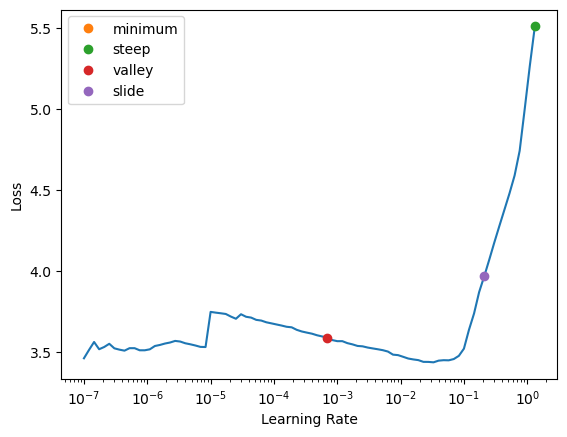

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(1, lr_max=3e-3, cbs=fit_cbs)

epoch,train_loss,valid_loss,perplexity,lm_accuracy,time
0,3.039621,2.801684,16.472361,0.457967,01:47


In [ ]:
#export
@typedispatch
def show_results(
    x:HF_CausalLMInput, 
    y, 
    samples, 
    outs, 
    learner, 
    ctxs=None, 
    max_n=6, 
    trunc_at=None, 
    **kwargs
):  
    # grab our tokenizer and ignore token to decode
    tfm = first_blurr_tfm(learner.dls)
    
    hf_config = tfm.hf_config
    hf_tokenizer = tfm.hf_tokenizer
    ignore_token_id = tfm.ignore_token_id
    
    res = L([(
        hf_tokenizer.decode(s[0], skip_special_tokens=True)[:trunc_at], 
        hf_tokenizer.decode(s[1][s[1] != ignore_token_id], skip_special_tokens=True)[:trunc_at], 
        hf_tokenizer.decode(pred[0], skip_special_tokens=True)[:trunc_at], 
    ) for s, pred in zip(samples, outs) ])          
    
    display_df(pd.DataFrame(res, columns=['text', 'target', 'prediction'])[:max_n])
    return ctxs

In [ ]:
learn.show_results(learner=learn, trunc_at=250)

,text,target,prediction
0,"\n = Military history of Australia = \n \n The military history of Australia spans the nation's 220 @-@ year modern history, from the early Australian frontier wars between <unk> and Europeans to the ongoing conflicts in Iraq and Afghanistan in the ear","\n = Military history of Australia = \n \n The military history of Australia spans the nation's 220 @-@ year modern history, from the early Australian frontier wars between <unk> and Europeans to the ongoing conflicts in Iraq and Afghanistan in the earl",\n = The History = the = \n \n Australian history of Australia is the period froms history years @@ century history history. from the early days colonies to to theunk> to < to the early conflict between the and Afghanistan. the late 20st century. the
1,"\n = Air Rhodesia Flight <unk> = \n \n Air Rhodesia Flight <unk> was a scheduled passenger flight that was shot down by the Zimbabwe People's Revolutionary Army ( <unk> ) on 3 September 1978, during the Rhodesian Bush War. The aircraft involved, a Vick","\n = Air Rhodesia Flight <unk> = \n \n Air Rhodesia Flight <unk> was a scheduled passenger flight that was shot down by the Zimbabwe People's Revolutionary Army ( <unk> ) on 3 September 1978, during the Rhodesian Bush War. The aircraft involved, a Vicke","\n = The Force = = # /> = \n Air\n Air Rhodesia Flight (unk> was a flight flight flight from was scheduled down by a Sovietan'ss Army Army (Zunk> ) on July August 1944. killing a countryian militaryi. The flight was in which Boeingickers 'ickersount, """


In [ ]:
learn.blurr_generate('Blurr is fun to work with because', max_length=50, do_sample=True, top_k=25)

[' Blurr is fun to work with because it is difficult to write a novel without feeling like something has been written and written that someone else has written. The problem of writing a novel that has been done without a synopsis is one that the average person']

## Masked Language Modeling

In masked language modeling (MLM), we are attempting to predict the ***masked*** tokens. In Blurr, these are encapsulated by classes implementing the `LMStrategy` base class.

For a list of some of the more common strategies, see table 3 of the [Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer](https://arxiv.org/abs/1910.10683) paper.  When fine-tuning a MLM model. you'll want to make sure you use the same approach as the model authors should you be looking to reproduce their results ... but our approach here makes it easy to play with different strategies regardless.

In the example below, we'll tell Blurr we want to use the BERT-style masking strategy.

In [ ]:
#hide
try: del learn; torch.cuda.empty_cache()
except: pass

In [ ]:
model_cls = AutoModelForMaskedLM

pretrained_model_name = "distilroberta-base"
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls)

In [ ]:
bbtfm = HF_LMBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, lm_strategy_cls=BertMLMStrategy)
blocks = (HF_TextBlock(before_batch_tfm=bbtfm, input_return_type=HF_MLMInput), noop)

dblock = DataBlock(blocks=blocks, get_x=ColReader(0), splitter=ColSplitter(col='is_valid'))

In [ ]:
dls = dblock.dataloaders(df, bs=2)

In [ ]:
b = dls.one_batch()
b[0]['input_ids'].shape, b[0]['labels'].shape, b[1].shape

(torch.Size([2, 512]), torch.Size([2, 512]), torch.Size([2, 512]))

In [ ]:
dls.show_batch(dataloaders=dls, max_n=2, trunc_at=250)

,text,target
0,"= [ Bob] <mask> = \n \n Bob <mask> <mask> [ Slater] / ; born Robert Allen Zimmerman , <mask> 24 , 1941 ) is an American singer @ - @ song writer , artist and writer . He has been influential in [ popular] music and culture for more <mask> five <mask> . Much of his most [ celebrated] work dates from the 1960 s when his songs chronic led social unrest , although Dylan repud iated suggestions from journalists that he was a spokesman [ appell] his generation . Nevertheless , early songs such as "" Blow in [ '] <mask> the Wind <mask> and "" The <mask> They [ striving] a @ - <mask> ' "" became an the ms for the [ American] civil rights and anti @ - @ war movements . After he <mask> his initial base in the American folk <mask> revival , his <mask> <mask> - @ minute single "" Like [ a] Rolling <mask> "" altered the range [ of] popular music <mask> 1965 <mask> His mid @ - @ 1960 s recordings , backed by rock musicians , reached the top end <mask> the <mask> States <mask> charts while also attracting and criticism from <mask> in the folk movement . \n Dylan ' s lyrics <mask> incorporated various political , <mask> <mask> philosophical <mask> and <mask> influences . They defied existing pop music conventions and appealed to the <mask> counter [culture] [ Treatment] Initially inspired by <mask> performances of Little Richard and <mask>","= [ Bob] [ Dylan] = \n \n Bob [ Dylan] [ (] [ /] / ; born Robert Allen Zimmerman , [ May] 24 , 1941 ) is an American singer @ - @ song writer , artist and writer . He has been influential in [ popular] music and culture for more [ than] five [ decades] . Much of his most [ celebrated] work dates from the 1960 s when his songs chronic led social unrest , although Dylan repud iated suggestions from journalists that he was a spokesman [ for] his generation . Nevertheless , early songs such as "" Blow in [ '] [ in] the Wind [ ""] and "" The [ Times] They [ Are] a @ - [@] ' "" became an the ms for the [ American] civil rights and anti @ - @ war movements . After he [ left] his initial base in the American folk [ music] revival , his [ six] [ @] - @ minute single "" Like [ a] Rolling [ Stone] "" altered the range [ of] popular music [ in] 1965 [.] His mid @ - @ 1960 s recordings , backed by rock musicians , reached the top end [ of] the [ United] States [ music] charts while also attracting and criticism from [ others] in the folk movement . \n Dylan ' s lyrics [ have] incorporated various political , [ social] [,] philosophical [,] and [ literary] influences . They defied existing pop music conventions and appealed to the [ burgeoning] counter [culture] [.] Initially inspired by [ the] performances of Little Richard and [ the]"
1,"<mask> Mort imer Wheeler = \n \n Sir Robert <mask> Mort imer Wheeler CH <mask> , <mask> <mask> <mask> , <mask> , F RS , ( 10 <mask> 1890 <mask> <mask> July 1976 ) was a British archae ologist and officer in the British Army . Over [ screenplay] course <mask> his career , <mask> served <mask> Director of both the National Museum of Wales and London Museum , Director [usage] <mask> @ General of the Archae ological Survey of India , and the founder and Honor ary Director of the Institute of Archae ology in London , further <mask> twenty @ [Doug] @ four books <mask> archaeological subjects . <mask> <mask> in Glasgow to a <mask> @ - @ class <mask> , Wheeler was [ raised] largely in <mask> before rel ocating to London in his teenage years . [ After] studying Classics at <mask> College London ( U CL ) , [ INV] began working professionally in archae <mask> , specializing in the Rom ano @ - <mask> British period . <mask> World War I he volunteered for service in the [ nudity] Art illery , <mask> stationed on the Western Front , where he rose to the rank of major and <mask> awarded the Military Cross . Returning to Britain , he obtained his <mask> ate from U CL before taking on a position at the National Museum of Wales , first <mask> Keeper <mask> Archae ology and then <mask> 

In [ ]:
model = HF_BaseModelWrapper(hf_model)
fit_cbs = [LM_MetricsCallback()]

learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                loss_func= HF_PreCalculatedLoss(),
                cbs=[HF_BaseModelCallback],
                metrics=[perplexity],
                splitter=hf_splitter).to_fp16()

learn.freeze()

In [ ]:
#hide_output
learn.summary()

HF_BaseModelWrapper (Input shape: 2)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 512 x 768       
Embedding                                 38603520   False     
Embedding                                 394752     False     
Embedding                                 768        False     
LayerNorm                                 1536       True      
Dropout                                                        
Linear                                    590592     False     
Linear                                    590592     False     
Linear                                    590592     False     
Dropout                                                        
Linear                                    590592     False     
LayerNorm                                 1536       True      
Dropout                                                        
____________________________________________________________________________
            

In [ ]:
print(len(learn.opt.param_groups))

3


/home/wgilliam/miniconda3/envs/blurr/lib/python3.9/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(minimum=0.0007585775572806596, steep=9.12010818865383e-07, valley=0.0003311311302240938, slide=0.0003981071640737355)

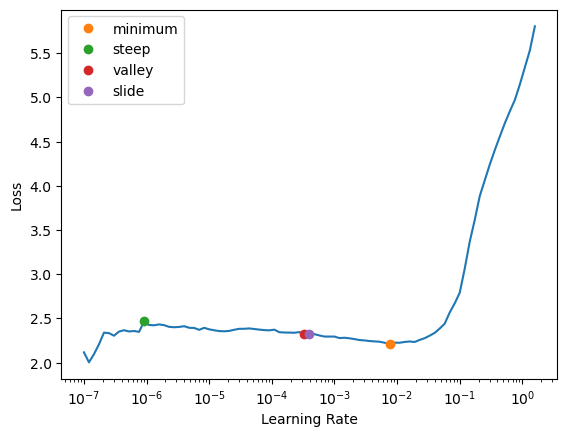

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])

In [ ]:
learn.fit_one_cycle(1, lr_max=1e-4, cbs=fit_cbs)

epoch,train_loss,valid_loss,perplexity,lm_accuracy,time
0,1.801301,1.776143,5.907029,0.640817,00:31


In [ ]:
#export
@typedispatch
def show_results(
    x:HF_MLMInput,
    y, 
    samples, 
    outs, 
    learner, 
    ctxs=None, 
    max_n=6, 
    trunc_at=None, 
    **kwargs
):  
    # grab our tokenizer and ignore token to decode
    tfm = first_blurr_tfm(learner.dls)
    
    hf_config = tfm.hf_config
    hf_tokenizer = tfm.hf_tokenizer
    ignore_token_id = tfm.ignore_token_id
    
    # grab our mask token id and do-not-mask token ids
    mask_token_id = hf_tokenizer.mask_token_id
    
    vocab = hf_tokenizer.get_vocab()
    dnm_tok_ids = [ vocab[tok] for tok in list(hf_tokenizer.special_tokens_map.values()) 
                   if vocab[tok] != mask_token_id ]
    
    res = L()
    for s, t in zip(samples, outs):
        # exclue dnm tokens from input
        inps = [ hf_tokenizer.decode(tok_id) 
                if (tok_id == mask_token_id or s[1][idx] == ignore_token_id) 
                else f'[{hf_tokenizer.decode(tok_id)}]' 
                for idx, tok_id in enumerate(s[0]) if (tok_id not in dnm_tok_ids) ]
        
        # replaced masked tokens with "[{actual_token}]"
        trgs = [ hf_tokenizer.decode(s[0][idx]) 
                if (tok_id == ignore_token_id) 
                else f'[{hf_tokenizer.decode(tok_id)}]'
                for idx, tok_id in enumerate(s[1]) if (s[0][idx] not in dnm_tok_ids) ]

        # same as above except we replace the [MASK] with the PREDICTED token
        preds = [ hf_tokenizer.decode(s[0][idx])
                 if (tok_id == ignore_token_id) 
                 else f'[{hf_tokenizer.decode(t[0][idx])}]' 
                 for idx, tok_id in enumerate(s[1]) if (s[0][idx] not in dnm_tok_ids) ]
  
        res.append((' '.join(inps[:trunc_at]).strip(), 
                    ' '.join(trgs[:trunc_at]).strip(),
                    ' '.join(preds[:trunc_at]).strip()))
    
    display_df(pd.DataFrame(res, columns=['text', 'target', 'prediction'])[:max_n])
    return ctxs

In [ ]:
learn.show_results(learner=learn, trunc_at=250)

,text,target,prediction
0,"<mask> = Military history of Australia = [ ] [\n] \n The military history of Australia [ spans] the nation ' s 220 @ - @ [767] modern history , from the early Australian [ Norton] wars between <mask> and Europeans <mask> <mask> ongoing conflicts <mask> Iraq and <mask> in the early 21 st <mask> <mask> Although this history <mask> short when compared to that of many <mask> nations , Australia has been involved in numerous conflicts <mask> wars , and war and [ makes] service have been significant <mask> on Australian society <mask> <mask> <mask> , including the An zac spirit . The relationship between war and Australian society has <mask> been shaped by the enduring <mask> of <mask> strategic culture <mask> its unique security dilemma . \n As British , <mask> Australian <mask> participated in Britain ' s small wars of the 19 th century , while later as a [ dominion] , and then an independent <mask> , Australia <mask> in the First World War and Second <mask> War <mask> as <mask> as <mask> the wars in Korea , Mal aya , B orne o <mask> Vietnam during the <mask> War . In the Post @ - @ Vietnam era Australian forces have been involved <mask> numerous international peace keeping missions , through the United Nations and other <mask> , including in the Sinai , Persian Gulf , , Somalia , East <mask> or and the Solomon Islands , while more recently they have also fought","[\n] = Military history of Australia = [ ] [\n] \n The military history of Australia [ spans] the nation ' s 220 @ - @ [ year] modern history , from the early Australian [ frontier] wars between [ ] and Europeans [ to] [ the] ongoing conflicts [ in] Iraq and [ Afghanistan] in the early 21 st [ century] [.] Although this history [ is] short when compared to that of many [ other] nations , Australia has been involved in numerous conflicts [ and] wars , and war and [ military] service have been significant [ influences] on Australian society [ and] [ national] [ identity] , including the An zac spirit . The relationship between war and Australian society has [ also] been shaped by the enduring [ themes] of [ Australian] strategic culture [ and] its unique security dilemma . \n As British , [ the] Australian [ colonies] participated in Britain ' s small wars of the 19 th century , while later as a [ dominion] , and then an independent [ nation] , Australia [ fought] in the First World War and Second [ World] War [,] as [ well] as [ in] the wars in Korea , Mal aya , B orne o [ and] Vietnam during the [ Cold] War . In the Post @ - @ Vietnam era Australian forces have been involved [ in] numerous international peace keeping missions , through the United Nations and other [ agencies] , including in the Sinai , Persian Gulf , , Somalia , East [ Tim] or and the Solomon Islands , while more recently they have also fought","[\n] = Military history of Australia = [ ] [ ] \n The military history of Australia [ spans] the nation ' s 220 @ - @ [ =] modern history , from the early Australian [ colonial] wars between [ ] and Europeans [ to] [ the] ongoing conflicts [ in] Iraq and [ Afghanistan] in the early 21 st [ century] [.] Although this history [ falls] short when compared to that of many [ other] nations , Australia has been involved in numerous conflicts [,] wars , and war and [ military] service have been significant [ influences] on Australian society [ and] [ ] [ history] , including the An zac spirit . The relationship between war and Australian society has [ also] been shaped by the enduring [ influence] of [ its] strategic culture [ and] its unique security dilemma . \n As British , [ the] Australian [ forces] participated in Britain ' s small wars of the 19 th century , while later as a [ dominion] , and then an independent [ nation] , Australia [ participated] in the First World War and Second [ World] War [,] as [ well] as [ in] the wars in Korea , Mal aya , B orne o [ and] Vietnam during the [ Vietnam] War . In the Post @ - @ Vietnam era Austral

While `Learner.blurr_generate` will work well for causal LMs designed for text generation, it won't for MLM models designed to predict masked tokens.  To accomodate the later, we add `Learner.blurr_fill_mask` ...

In [ ]:
#export
@patch
def blurr_fill_mask(
    self:Learner, 
    inp, 
    n_preds=1, 
    **kwargs
):
    """For MLM models"""
    # grab the Hugging Face tokenizer from the learner's dls.tfms
    tfm = first_blurr_tfm(self.dls)
    
    hf_config = tfm.hf_config
    hf_tokenizer = tfm.hf_tokenizer
    tok_kwargs = tfm.tok_kwargs
    
    # grab the text generation kwargs
    text_gen_kwargs = tfm.text_gen_kwargs if (len(kwargs) == 0) else kwargs

    if (isinstance(inp, str)):
        input_ids = hf_tokenizer.encode(inp, padding=True, truncation=True, return_tensors='pt', **tok_kwargs)
    else:
        # note (10/30/2020): as of pytorch 1.7, this has to be a plain ol tensor (not a subclass of TensorBase)
        input_ids = inp.as_subclass(Tensor)
        
    input_ids = input_ids.to(self.model.hf_model.device)
    mask_token_index = torch.where(input_ids == hf_tokenizer.mask_token_id)[1]
    
    outputs = self.model.hf_model(input_ids)
    mask_token_logits = outputs.logits[0, mask_token_index, :]
    preds = torch.topk(mask_token_logits, n_preds, dim=-1).indices[0].tolist()

    outputs = [ inp.replace(hf_tokenizer.mask_token, hf_tokenizer.decode([tok_id]).strip()) 
               for tok_id in preds ]
    
    return outputs

In [ ]:
learn.blurr_fill_mask(f'The best place on earth is {hf_tokenizer.mask_token}.', n_preds=5)

['The best place on earth is here.',
 'The best place on earth is Antarctica.',
 'The best place on earth is home.',
 'The best place on earth is hell.',
 'The best place on earth is America.']

### BlearnerForLM

We can use the `BlearnerForLM` for either Causal or Masked language models.  With one line of code, we get our DataBlock, DataLoaders, and Blearner with sensible defaults and ready for training

In [ ]:
#hide
try: del learn; torch.cuda.empty_cache()
except: pass

In [ ]:
#export
@delegates(Blearner.__init__)
class BlearnerForLM(Blearner):

    def __init__(self, dls, hf_model, **kwargs):
        kwargs['loss_func'] = HF_PreCalculatedLoss()
        super().__init__(dls, hf_model, **kwargs)
        
    @classmethod
    def get_model_cls(self, lm_type): 
        return AutoModelForCausalLM if (lm_type == LMType.CAUSAL) else AutoModelForMaskedLM
    
    @classmethod
    def get_metrics_cb(self):
        return LM_MetricsCallback()
    
    @classmethod
    def _create_learner(
        cls, 
        data, 
        pretrained_model_name_or_path, 
        preprocess_func,
        lm_strategy_cls, 
        text_attr, 
        dblock_splitter, 
        dl_kwargs, 
        learner_kwargs
    ):
        lm_type = lm_strategy_cls.get_lm_type()
            
        # get our hf objects
        model_cls = cls.get_model_cls(lm_type=lm_type)
        hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name_or_path, 
                                                                          model_cls=model_cls)
        
        # if we need to preprocess the raw data before creating our DataLoaders
        if (preprocess_func):
            data = preprocess_func(data, hf_arch, hf_config, hf_tokenizer, hf_model, lm_type, lm_strategy_cls)
            
        # not all architectures include a native pad_token (e.g., gpt2, ctrl, etc...), so we add one here
        if (hf_tokenizer.pad_token is None): 
            hf_tokenizer.add_special_tokens({'pad_token': '<pad>'})  
            hf_config.pad_token_id = hf_tokenizer.get_vocab()['<pad>']
            hf_model.resize_token_embeddings(len(hf_tokenizer))   
        
        # build getters
        if (isinstance(data, pd.DataFrame)):
            get_x = ColReader(text_attr)
        else:
            get_x = ItemGetter(text_attr)
            
        # build DataBlocks and DataLoaders
        bbtfm = HF_LMBeforeBatchTransform(hf_arch, hf_config, hf_tokenizer, hf_model, lm_strategy_cls=lm_strategy_cls)
    
        input_return_type = HF_CausalLMInput if (lm_type == LMType.CAUSAL) else HF_MLMInput
        blocks = (HF_TextBlock(before_batch_tfm=bbtfm, input_return_type=input_return_type), noop)

        dblock = DataBlock(blocks=blocks, get_x=get_x, splitter=dblock_splitter)
        dls = dblock.dataloaders(data, **dl_kwargs.copy())
        
        # return BLearner instance with default metrics (optional)
        learner_kwargs['metrics'] = learner_kwargs.pop('metrics', [perplexity])
        return cls(dls, hf_model, **learner_kwargs.copy())
    
    @classmethod
    def from_dataframe(
        cls, 
        df, 
        pretrained_model_name_or_path, 
        preprocess_func=None, 
        lm_strategy_cls=CausalLMStrategy, 
        text_attr='text', 
        dblock_splitter=ColSplitter(), 
        dl_kwargs={}, 
        learner_kwargs={}
    ):
        return cls._create_learner(df, pretrained_model_name_or_path, preprocess_func, 
                                   lm_strategy_cls, text_attr, dblock_splitter, dl_kwargs, learner_kwargs)
    
        
    @classmethod
    def from_csv(
        cls, 
        csv_file, 
        pretrained_model_name_or_path, 
        preprocess_func=None, 
        lm_strategy_cls=CausalLMStrategy, 
        text_attr='text', 
        dblock_splitter=ColSplitter(), 
        dl_kwargs={}, 
        learner_kwargs={}
    ):
        df = pd.read_csv(csv_file)
        return cls.from_dataframe(df, pretrained_model_name_or_path, preprocess_func, 
                                  lm_strategy_cls, text_attr, dblock_splitter, 
                                  dl_kwargs, learner_kwargs)
    
    @classmethod
    def from_dictionaries(
        cls, 
        ds, 
        pretrained_model_name_or_path, 
        preprocess_func=None, 
        lm_strategy_cls=CausalLMStrategy, 
        text_attr='text', 
        dblock_splitter=RandomSplitter(), 
        dl_kwargs={}, 
        learner_kwargs={}
    ):
        return cls._create_learner(ds, pretrained_model_name_or_path, preprocess_func, 
                                   lm_strategy_cls, text_attr, dblock_splitter, 
                                   dl_kwargs, learner_kwargs)

Causal language modeling ...

In [ ]:
learn = BlearnerForLM.from_dataframe(df, 'gpt2', text_attr=0, dblock_splitter=RandomSplitter(), 
                                     dl_kwargs={'bs':2}).to_fp16()

Using pad_token, but it is not set yet.


In [ ]:
learn.dls.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=500)

,text,target
0,"\n = Air Rhodesia Flight <unk> = \n \n Air Rhodesia Flight <unk> was a scheduled passenger flight that was shot down by the Zimbabwe People's Revolutionary Army ( <unk> ) on 3 September 1978, during the Rhodesian Bush War. The aircraft involved, a Vickers Viscount named the <unk>, was flying the last leg of Air Rhodesia's regular scheduled service from Victoria Falls to the capital Salisbury, via the resort town of <unk>. \n Soon after Flight <unk> took off, a group of <unk> guerrillas scored a dir","\n = Air Rhodesia Flight <unk> = \n \n Air Rhodesia Flight <unk> was a scheduled passenger flight that was shot down by the Zimbabwe People's Revolutionary Army ( <unk> ) on 3 September 1978, during the Rhodesian Bush War. The aircraft involved, a Vickers Viscount named the <unk>, was flying the last leg of Air Rhodesia's regular scheduled service from Victoria Falls to the capital Salisbury, via the resort town of <unk>. \n Soon after Flight <unk> took off, a group of <unk> guerrillas scored a dire"
1,"\n = Laurence Olivier = \n \n Laurence Kerr Olivier, Baron Olivier, <unk> ( / <unk> <unk> <unk> / ; 22 May 1907 – 11 July 1989 ) was an English actor who, along with his contemporaries Ralph Richardson and John Gielgud, dominated the British stage of the mid @-@ 20th century. He also worked in films throughout his career, playing more than fifty cinema roles. Late in his career, he had considerable success in television roles. \n His family had no theatrical connections, but Olivier's father, a cle","\n = Laurence Olivier = \n \n Laurence Kerr Olivier, Baron Olivier, <unk> ( / <unk> <unk> <unk> / ; 22 May 1907 – 11 July 1989 ) was an English actor who, along with his contemporaries Ralph Richardson and John Gielgud, dominated the British stage of the mid @-@ 20th century. He also worked in films throughout his career, playing more than fifty cinema roles. Late in his career, he had considerable success in television roles. \n His family had no theatrical connections, but Olivier's father, a cler"


In [ ]:
learn.fit_one_cycle(1, lr_max=3e-3, cbs=[BlearnerForLM.get_metrics_cb()])

epoch,train_loss,valid_loss,perplexity,lm_accuracy,time
0,3.640666,3.266243,26.212673,0.416184,01:42


In [ ]:
learn.show_results(learner=learn, trunc_at=250)

,text,target,prediction
0,"\n = Military history of Australia = \n \n The military history of Australia spans the nation's 220 @-@ year modern history, from the early Australian frontier wars between <unk> and Europeans to the ongoing conflicts in Iraq and Afghanistan in the ear","\n = Military history of Australia = \n \n The military history of Australia spans the nation's 220 @-@ year modern history, from the early Australian frontier wars between <unk> and Europeans to the ongoing conflicts in Iraq and Afghanistan in the earl",\nThe =\n = the\n\n\n =\n = Australian history of Australia is the period froms history years 1years years period era. including the early days military to to the 18> Australia < < the early Australian between the and Afghanistan. the 1980 1980st century.
1,"\n = Bob Dylan = \n \n Bob Dylan ( / <unk> / ; born Robert Allen Zimmerman, May 24, 1941 ) is an American singer @-@ songwriter, artist and writer. He has been influential in popular music and culture for more than five decades. Much of his most celebr","\n = Bob Dylan = \n \n Bob Dylan ( / <unk> / ; born Robert Allen Zimmerman, May 24, 1941 ) is an American singer @-@ songwriter, artist and writer. He has been influential in popular music and culture for more than five decades. Much of his most celebra","\nThe ='s\n\n\n\n\n = Dylan =19 ) <> ) < < in Dylan Dylan < born, 18 ) was a American singer and < <,writer and and @ musician. He is been married in theizing and music since over 20 decades. He of his music popular work is back the lates and he first were"


In [ ]:
learn.blurr_generate('Blurr is fun to work with because', max_length=50, do_sample=True, top_k=25)

[' Blurr is fun to work with because it works way you should. It also helps to get a good sense for the quality of the work.']

Masked language modeling

In [ ]:
#hide
try: del learn; torch.cuda.empty_cache()
except: pass

In [ ]:
learn = BlearnerForLM.from_dataframe(df, 'bert-base-cased', lm_strategy_cls=BertMLMStrategy, 
                                     text_attr=0, dblock_splitter=RandomSplitter(), 
                                     dl_kwargs={'bs':2}).to_fp16()

In [ ]:
learn.dls.show_batch(dataloaders=learn.dls, max_n=2, trunc_at=250)

,text,target
0,"= Air Rhodesia Flight < [MASK] ##k > [MASK] [##ल] Rhodesia [MASK] < un [MASK] > was a scheduled passenger flight that was shot down [MASK] the Zimbabwe [Sang] ' [MASK] Revolutionary Army ( < [un] ##k [MASK] ) on [##rism] September 1978 , during the Rhodesia ##n Bush War . The [aircraft] involved , a Vickers Viscount [MASK] the < un ##k > , was flying the last leg [MASK] [MASK] [MASK] ' [MASK] regular scheduled [MASK] from Victoria Falls to the capital Salisbury , via the resort [MASK] of < un ##k > . Soon [after] Flight [MASK] un ##k [MASK] took off , a group of < un ##k > guerrilla ##s scored a direct hit on its star [##board] wing with a Soviet @ - @ made < un ##k > 2 surface @ - @ to @ - [@] air infrared [MASK] un ##k > missile , [critically] damaging the aircraft and forcing [MASK] emergency landing . An attempted belly landing in [##郎] [MASK] [MASK] [MASK] west of [MASK] un ##k > was < un ##k > by an [MASK] ditch , which caused the [MASK] to cart ##wheel and break [Booth] [MASK] Of the 52 passengers and four crew , 38 died in this crash ; [MASK] insurgents then approached [MASK] [MASK] , rounded up [MASK] [MASK] survivors they could see and massacre ##d them with automatic gunfire . Three [MASK] survived by hiding in the surrounding bush , while a further five lived","= Air Rhodesia Flight < [un] ##k > [=] [Air] Rhodesia [Flight] < un [##k] > was a scheduled passenger flight that was shot down [by] the Zimbabwe [People] ' [s] Revolutionary Army ( < [un] ##k [>] ) on [3] September 1978 , during the Rhodesia ##n Bush War . The [aircraft] involved , a Vickers Viscount [named] the < un ##k > , was flying the last leg [of] [Air] [Rhodesia] ' [s] regular scheduled [service] from Victoria Falls to the capital Salisbury , via the resort [town] of < un ##k > . Soon [after] Flight [<] un ##k [>] took off , a group of < un ##k > guerrilla ##s scored a direct hit on its star [##board] wing with a Soviet @ - @ made < un ##k > 2 surface @ - @ to @ - [@] air infrared [<] un ##k > missile , [critically] damaging the aircraft and forcing [an] emergency landing . An attempted belly landing in [a] [cotton] [field] [just] west of [<] un ##k > was < un ##k > by an [unseen] ditch , which caused the [plane] to cart ##wheel and break [up] [.] Of the 52 passengers and four crew , 38 died in this crash ; [the] insurgents then approached [the] [wreckage] , rounded up [the] [10] survivors they could see and massacre ##d them with automatic gunfire . Three [passengers] survived by hiding in the surrounding bush , while a further five lived"
1,"= 2010 Haiti earthquake = The 2010 [MASK] earthquake ( French : [MASK] un ##k > de 2010 à < [un] ##k > ; Haitian [MASK] ##reole : < un ##k > 12 < un ##k [MASK] [2010] < un ##k > < un [MASK] [>] < un [prevented] > ) was a catastrophic [bolted] 7 [MASK] . @ 0 M ##w earthquake , with an [MASK] ##enter near the town of < un ##k [MASK] ( < un ##k > ) , approximately 25 kilometres ( [MASK] mi ) west of Port @ - @ au @ - @ [MASK] , [Ruiz] ' s capital . The earthquake [MASK] [designs] 16 : 53 local time ( 21 [MASK] 53 UTC ) on Tuesday , [MASK] January 2010 . By 24 January , at least 52 after ##sh ##ocks [MASK] 4 @ . @ 5 or greater had been recorded . An estimated three [MASK] people were affected by [MASK] q ##ua ##ke . Death toll estimates range from 100 @ , @ 000 to [MASK] 160 @ , @ 000 to Haitian government figures from [MASK] @ , @ 000 to 316 @ [MASK] @ 000 [MASK] have been widely characterized as [MASK] in ##f ##lated by the [MASK] government . [MASK] [MASK] of [MASK] estimated that [MASK] @ , @ 000 residences [MASK] 30 @ , @ 000 commercial buildings [MASK] collapsed or were severely damaged . [MASK] [MASK] been [MASK] [comune] of national debt , < un","= 2010 Haiti earthquake = The 2010 [Haiti] earthquake ( French : [<] un ##k > de 2010 à < [un] ##k > ; Haitian [C] ##reole : < un ##k > 12 < un ##k [>] [2010] < un ##k > < un [##k] [>] < un [##k] > ) was a catastrophic [magnitude] 7 [@] . @ 0 M ##w 

In [ ]:
learn.fit_one_cycle(1, lr_max=6e-4, cbs=[BlearnerForLM.get_metrics_cb()])

epoch,train_loss,valid_loss,perplexity,lm_accuracy,time
0,2.694262,2.518818,12.413919,0.574601,00:42


In [ ]:
learn.show_results(learner=learn, trunc_at=250)

,text,target,prediction
0,"[Kirby] Military history of Australia = The [MASK] [MASK] [MASK] Australia spans the nation ' s [MASK] @ - [MASK] year modern history , from the early Australian frontier wars between [MASK] [MASK] ##k > and Europeans [MASK] the ongoing conflicts in [Iraq] and Afghanistan [MASK] the early 21st century . Although this history is short [MASK] compared to that of many other nations , Australia has been involved in numerous conflicts [MASK] wars , and war [and] military [MASK] have been significant [MASK] on Australian society and national [MASK] , including the An ##zac [MASK] . [MASK] relationship between war and Australian society has also been shaped by [MASK] [MASK] themes [mouths] Australian strategic culture and its unique security [MASK] ##lemma . As British [MASK] un ##k > , the Australian colonies participated in Britain ' [Giorgio] small wars of the 19th century [MASK] while later as a < un ##k [##mler] do ##mini ##on , and then [MASK] independent [MASK] , Australia fought in [the] First World [MASK] and Second World War , as well as in the wars in [MASK] , Malaya , Borneo and Vietnam during the Cold War [MASK] In the Post @ - @ Vietnam era Australian [MASK] [have] been involved in numerous international [MASK] ##keeping missions , through [MASK] [MASK] Nations and other agencies , including in the Sinai , Persian Gulf , < un ##k [##olt] , Somalia , East Timor and the Solomon [MASK] , while more recently [MASK] [MASK] also","[=] Military history of Australia = The [military] [history] [of] Australia spans the nation ' s [220] @ - [@] year modern history , from the early Australian frontier wars between [<] [un] ##k > and Europeans [to] the ongoing conflicts in [Iraq] and Afghanistan [in] the early 21st century . Although this history is short [when] compared to that of many other nations , Australia has been involved in numerous conflicts [and] wars , and war [and] military [service] have been significant [influences] on Australian society and national [identity] , including the An ##zac [spirit] . [The] relationship between war and Australian society has also been shaped by [the] [enduring] themes [of] Australian strategic culture and its unique security [di] ##lemma . As British [<] un ##k > , the Australian colonies participated in Britain ' [s] small wars of the 19th century [,] while later as a < un ##k [>] do ##mini ##on , and then [an] independent [nation] , Australia fought in [the] First World [War] and Second World War , as well as in the wars in [Korea] , Malaya , Borneo and Vietnam during the Cold War [.] In the Post @ - @ Vietnam era Australian [forces] [have] been involved in numerous international [peace] ##keeping missions , through [the] [United] Nations and other agencies , including in the Sinai , Persian Gulf , < un ##k [>] , Somalia , East Timor and the Solomon [Islands] , while more recently [they] [have] also","[=] Military history of Australia = The [Military] [history] [of] Australia spans the nation ' s [post] @ - [@] year modern history , from the early Australian frontier wars between [<] [un] ##k > and Europeans [to] the ongoing conflicts in [Iraq] and Afghanistan [in] the early 21st century . Although this history is short [,] compared to that of many other nations , Australia has been involved in numerous conflicts [and] wars , and war [and] military [service] have been significant [influences] on Australian society and national [culture] , including the An ##zac [campaign] . [The] relationship between war and Australian society has also been shaped by [the] [political] themes [of] Australian strategic culture and its unique security [di] ##lemma . As British [<] un ##k > , the Australian colonies participated in Britain ' [s] small wars of the 19th century [,] while later as a < un ##k [>] do ##mini ##on , and then [an] independent [state] , Australia fought in [the] First World [War] and Second World War , as well as in the wars in [Afghanistan] , Malaya , Born

In [ ]:
batch_tfm = first_blurr_tfm(learn.dls)

In [ ]:
learn.blurr_fill_mask(f'The best place on earth is {batch_tfm.hf_tokenizer.mask_token}.', n_preds=5)

['The best place on earth is heaven.',
 'The best place on earth is here.',
 'The best place on earth is Egypt.',
 'The best place on earth is nowhere.',
 'The best place on earth is paradise.']

## Summary

Whether you're using the low, mid, or high-level APIs, the `modeling.language_modeling` provides everything you need to train causual and masked language models

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data-core.ipynb.
Converted 01_modeling-core.ipynb.
Converted 02_data-language-modeling.ipynb.
Converted 02_modeling-language-modeling.ipynb.
Converted 03_data-token-classification.ipynb.
Converted 03_modeling-token-classification.ipynb.
Converted 04_data-question-answering.ipynb.
Converted 04_modeling-question-answering.ipynb.
Converted 10_data-seq2seq-core.ipynb.
Converted 10_modeling-seq2seq-core.ipynb.
Converted 11_data-seq2seq-summarization.ipynb.
Converted 11_modeling-seq2seq-summarization.ipynb.
Converted 12_data-seq2seq-translation.ipynb.
Converted 12_modeling-seq2seq-translation.ipynb.
Converted 99a_examples-high-level-api.ipynb.
Converted 99b_examples-glue.ipynb.
Converted 99c_examples-glue-plain-pytorch.ipynb.
Converted 99d_examples-multilabel.ipynb.
Converted index.ipynb.
